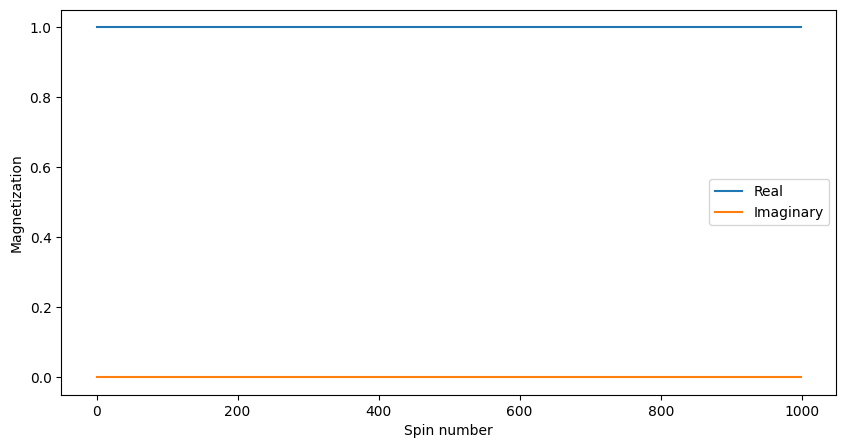

In [14]:
import numpy as np
import matplotlib.pyplot as plt

N_spins = 1000  # Number of spins in the phantom
phantom = np.ones(N_spins, dtype=np.complex128)  # All spins start in equilibrium state
#Plot the phantom
plt.figure(figsize=(10, 5))
plt.plot(np.real(phantom), label='Real')
plt.plot(np.imag(phantom), label='Imaginary')
plt.xlabel('Spin number')
plt.ylabel('Magnetization')
plt.legend()
plt.show()


In [15]:
angle = np.pi / 2  # 90 degree flip
phantom *= np.exp(1j * angle)  # Rotate each spin by 90 degrees
T1 = 1.0  # T1 relaxation time
T2 = 0.5  # T2 relaxation time

times = np.linspace(0, 5 * T2, 1000)  # Times at which to sample the signal
signal = np.zeros_like(times, dtype=np.complex128)

for i, t in enumerate(times):
    E1 = np.exp(-t / T1)
    E2 = np.exp(-t / T2)
    signal[i] = np.sum(phantom * E1 * E2)  # Signal is sum of all spins, with relaxation

Gx = 1.0  # Strength of the gradient field

# Apply the gradient field
for i in range(N_spins):
    signal *= np.exp(-1j * Gx * i * times)  # Frequency shift depends on position in the phantom


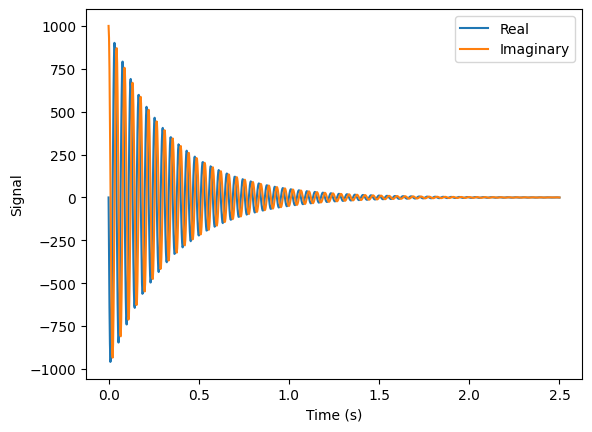

In [16]:
# Plot signal
import matplotlib.pyplot as plt

plt.figure()
plt.plot(times, signal.real, label='Real')
plt.plot(times, signal.imag, label='Imaginary')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.legend()
plt.show()
